In [49]:
import pandas as pd
import numpy as np
import matplotlib.colors as mc # For the legend
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.cm import ScalarMappable

#Plot defaults
import matplotlib as mpl
typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42


In [93]:
data = pd.read_csv('Data/phenotypes.csv')

exclusion_list = ['-1', '-2', '-3', '-4', '-5', '-6', '82a', '92a']

data = data[~data['site'].isin(exclusion_list)]
#Remove the ones with letters
data = data[~data['site'].str.contains('[a-zA-Z]')]
data['site'] = data['site'].astype(int).sort_values()

data.columns

#Select the columns that we want to plot: site, mutant, "species sera escape"
data = data[['site', 'mutant', 'species sera escape', 'sequential_site']]
data.columns

Index(['site', 'mutant', 'species sera escape', 'sequential_site'], dtype='object')

In [94]:
import pandas as pd

data = pd.read_csv('Data/phenotypes.csv')

exclusion_list = ['-1', '-2', '-3', '-4', '-5', '-6', '82a', '92a']

data = data[~data['site'].isin(exclusion_list)]
data = data[~data['site'].str.contains('[a-zA-Z]')]
data['site'] = data['site'].astype(int)
data = data.sort_values(by='site')

# Select columns

data['species sera escape'] = data['species sera escape'].fillna(0).round(4)

# Create a pivot table
data_pivot = data.pivot(index='site', columns='mutant', values='species sera escape')
data_pivot = data_pivot.fillna(0)

prot_site = data_pivot.index
prot_mutant = data_pivot.columns
prot_escape = data_pivot.values


In [95]:
def single_plot(prot_escape, prot_site, prot_mutant, ax):

    prot_escape = prot_escape.T
    ygrid = np.arange(len(prot_mutant) + 1)
    xgrid = np.arange(len(prot_site) + 1)

    # Plot the heatmap
    c = ax.pcolormesh(xgrid, ygrid, prot_escape, cmap="RdBu", shading='flat')

    max_site = max(prot_site)
    x_ticks = np.arange(0, len(prot_site)+1, 50)  

    x_tick_labels = [prot_site[i] for i in x_ticks if i < len(prot_site)]

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)

    # Set the y-axis ticks to each amino acid letter
    # Place ticks in the center of the cells
    ax.set_yticks(np.arange(len(prot_mutant)) + 0.5)
    ax.set_yticklabels(prot_mutant)

    # Remove tick marks by setting their length to 0
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)

    # Remove all spines
    ax.set_frame_on(False)

    return c  

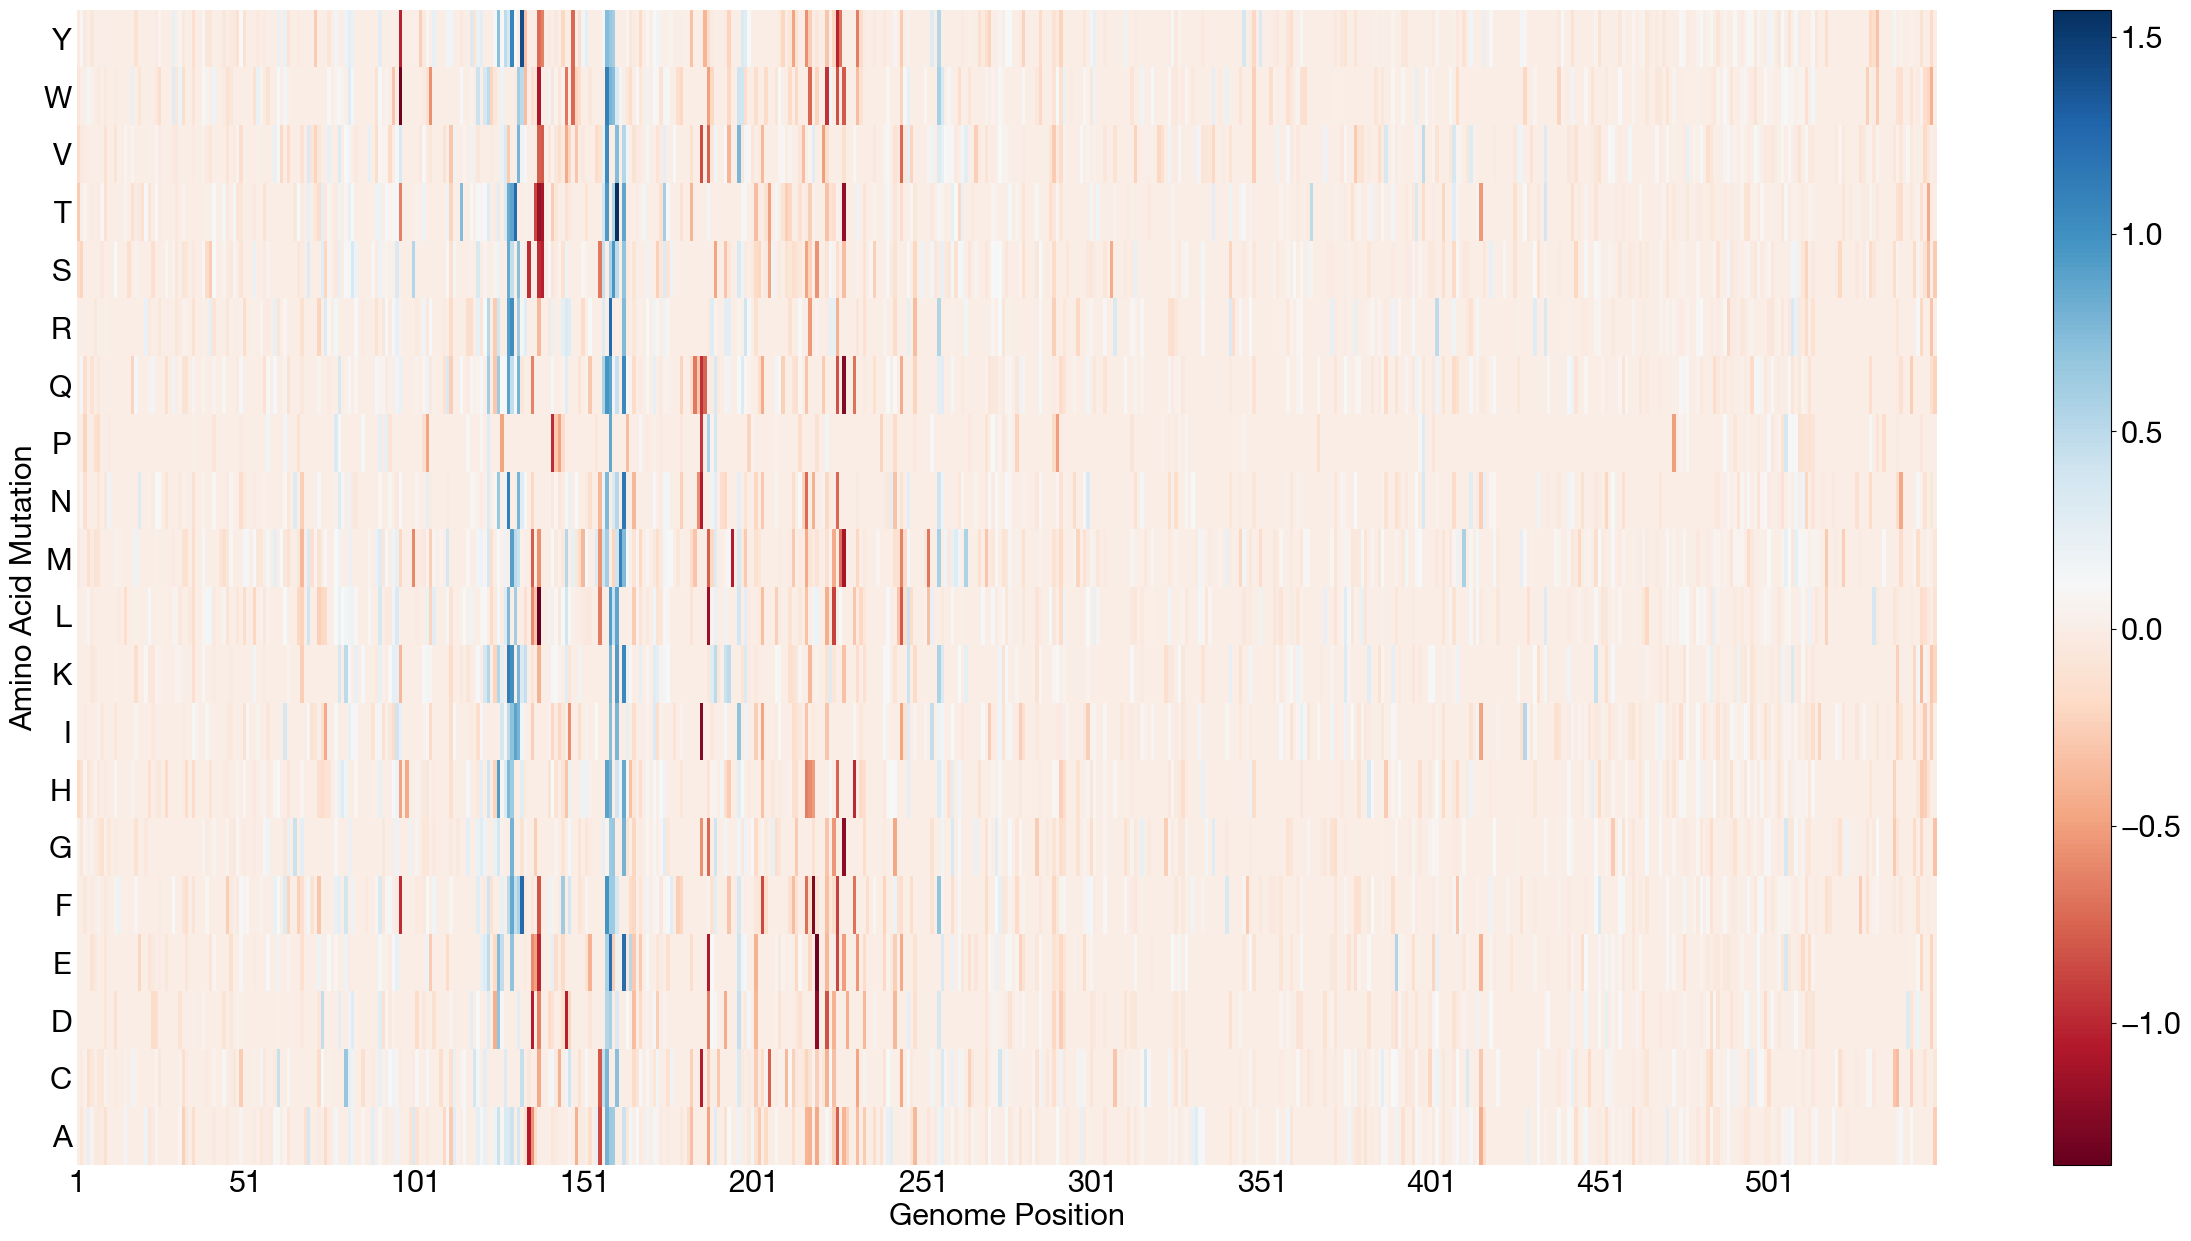

In [96]:
import matplotlib.pyplot as plt

# prot_escape: 2D numpy array (rows = amino acids, columns = positions)
# prot_mutant: list or array of amino acid single-letter codes corresponding to rows
# prot_site: list or array of genomic positions corresponding to columns

fig, ax = plt.subplots(figsize=(30, 15))

# Call the plotting function
c = single_plot(prot_escape, prot_site, prot_mutant, ax)

# Add a colorbar
plt.colorbar(c, ax=ax)

# Add axis labels and a title if desired
ax.set_xlabel("Genome Position")
ax.set_ylabel("Amino Acid Mutation")
ax.set_title(None)

# Save the figure
#plt.savefig("HA_mut_heatmap.jpeg", dpi=1200, bbox_inches='tight')
plt.show()

In [150]:
from Bio import SeqIO

# Load the reference sequence
ref_seq = "MENIVLLLAIVSLVKSDQICIGYHANNSTEQVDTIMEKNVTVTHAQDILEKTHNGKLCDLNGVKPLILKDCSVAGWLLGNPMCDEFIRVPEWSYIVERANPANDLCYPGSLNDYEELKHMLSRINHFEKILIIPKSSWPNHETSLGVSAACPYQGAPSFFRNVVWLIKKNDAYPTIKISYNNTNREDLLILWGIHHSNNAEEQTNLYKNPTTYISVGTSTLNQRLAPKIATRSQVNGQRGRMDFFWTILKPDDAIHFESNGNFIAPEYAYKIVKKGDSTIMKSGVEYGHCNTKCQTPVGAINSSMPFHNIHPLTIGECPKYVKSNKLVLATGLRNSPLREKRRKRGLFGAIAGFIEGGWQGMVDGWYGYHHSNEQGSGYAADKESTQKAIDGVTNKVNSIIDKMNTQFEAVGREFNNLERRIENLNKKMEDGFLDVWTYNAELLVLMENERTLDFHDSNVKNLYDKVRLQLRDNAKELGNGCFEFYHKCDNECMESVRNGTYDYPQYSEEARLKREEISGVKLESVGTYQILSIYSTAASSLALAIMMAGLSLWMCSNGSLQCRICI"  # Example reference sequence

# Parse clustered H5 sequences from FASTA
fasta_path = "Data/H5_GisaidData.clustered.fasta"
clustered_sequences = []
for record in SeqIO.parse(fasta_path, "fasta"):
    clustered_sequences.append(str(record.seq))

In [151]:
# Create a dictionary for fast lookup of escape values
mutation_to_escape = {}
for idx, row in data.iterrows():
    mutation_tag = f"{row['sequential_site']}{row['mutant']}"
    mutation_to_escape[mutation_tag] = row['species sera escape']

# Compute escape values for each clustered sequence
escape_values = []
mutations_per_sequence = []  # Store mutations for debugging/visualization

for seq in clustered_sequences:
    escape_score = 0.0
    sequence_mutations = []

    # Compare to reference sequence
    for i, (ref_residue, seq_residue) in enumerate(zip(ref_seq, seq)):
        if ref_residue != seq_residue:  # Mutation found
            mutation_tag = f"{i + 7}{seq_residue}"  # Use sequential_site offset (starts at 7)
            escape_score += mutation_to_escape.get(mutation_tag, 0.0)
            sequence_mutations.append(mutation_tag)

    escape_values.append(escape_score)
    mutations_per_sequence.append(sequence_mutations)

# Create a DataFrame for clustered sequences with escape values
clustered_df = pd.DataFrame({
    "sequence": clustered_sequences,
    "escape_value": escape_values,
    "mutations": mutations_per_sequence
})

print(clustered_df.head())

                                            sequence  escape_value  \
0  MEKIVLLLSVVGLVKSDQICIGYHANNSTEQVDTIMEKNVTVTHAQ...       -2.4319   
1  MENIVLLLAIVSLVKSDQICIGYHANNSTEQVDTIMEKNVTVTHAQ...       -0.0553   
2  MEKIVLLLSMVGLVKSDQICIGYHANNSTEQVDTIMEKNVTVTHAQ...       -2.3706   
3  MEKIVLLFATISLVKSDHICIGYHANNSTEQVDTIMEKNVTVTHAQ...        1.5797   
4  MEKIVLLFTTISLVKSDHICIGYHANNSTEQVDTIMEKNVTVTHAQ...        0.2966   

                                           mutations  
0  [9K, 15S, 16V, 18G, 76N, 94N, 116N, 126L, 136T...  
1  [58A, 73V, 75N, 105T, 126L, 131K, 162T, 185N, ...  
2  [9K, 15S, 16M, 18G, 76N, 94S, 116N, 126L, 136T...  
3  [9K, 14F, 16T, 17I, 24H, 88L, 93N, 94N, 104K, ...  
4  [9K, 14F, 15T, 16T, 17I, 24H, 88L, 94N, 104K, ...  


In [170]:
#Load transformer
from transformers import EsmTokenizer, EsmModel
import torch

tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t30_150M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t30_150M_UR50D")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [171]:
from tqdm.auto import tqdm
embeddings = []

for seq in tqdm(clustered_df["sequence"], desc="Generating Embeddings"):
    # Tokenize the sequence
    inputs = tokenizer(seq, return_tensors="pt", padding=True, truncation=True)
    
    # Get model outputs
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Compute mean embedding across tokens
    last_hidden_states = outputs.last_hidden_state
    embedding = last_hidden_states.mean(dim=1).detach().cpu().numpy().flatten()
    
    embeddings.append(embedding)

# Add embeddings to clustered_df
clustered_df["embedding"] = embeddings

Generating Embeddings:   0%|          | 0/591 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/200


/Users/ricardorivero/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/ricardorivero/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/ricardorivero/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - loss: 18.9325 - mae: 3.2601 - rmse: 3.3085 - val_loss: 0.5473 - val_mae: 0.6787 - val_rmse: 0.7363
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 1.0894 - mae: 0.9078 - rmse: 0.9997 - val_loss: 0.0905 - val_mae: 0.1904 - val_rmse: 0.2881
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.2655 - mae: 0.4058 - rmse: 0.5204 - val_loss: 0.1116 - val_mae: 0.2908 - val_rmse: 0.3247
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.2793 - mae: 0.4084 - rmse: 0.5257 - val_loss: 0.0971 - val_mae: 0.2560 - val_rmse: 0.3012
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.2281 - mae: 0.3758 - rmse: 0.4688 - val_loss: 0.0990 - val_mae: 0.2614 - val_rmse: 0.3046
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.2337 - mae: 0.3780 - rmse: 0.4750 - val_loss: 0.0976 - val_mae: 0.1892 - val_rmse: 0.3010
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.1916 - mae: 0.3396 - rmse: 0.4

/Users/ricardorivero/anaconda3/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


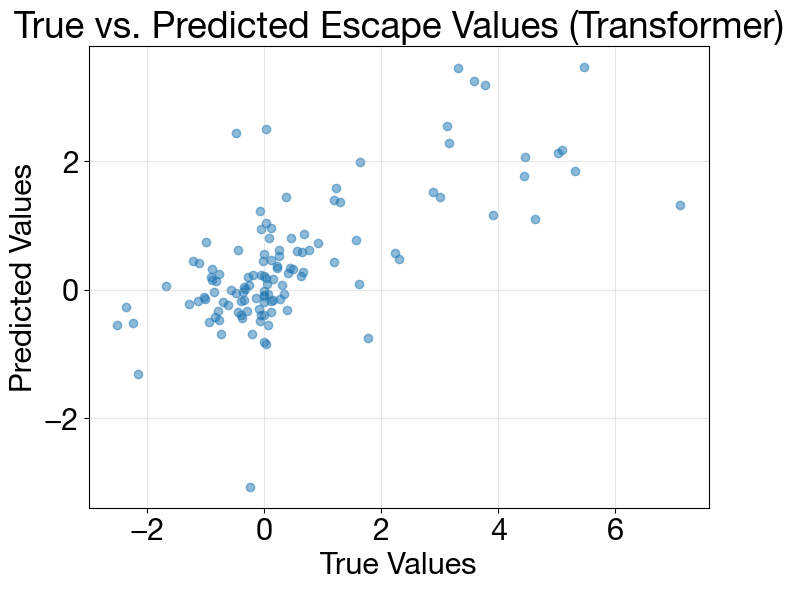

In [217]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam


# Normalize target values
scaler = MinMaxScaler(feature_range=(-1, 1))
escape_values_scaled = scaler.fit_transform(escape_values.reshape(-1, 1)).flatten()

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    embedding_array, escape_values_scaled, test_size=0.2, random_state=42
)

import tensorflow.keras.backend as K

def rmse(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

class PositionalEncoding(Layer):
    def __init__(self, max_seq_len, embed_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_seq_len = max_seq_len
        self.embed_dim = embed_dim
        self.pos_encoding = self.positional_encoding(max_seq_len, embed_dim)
        self.supports_masking = True

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def positional_encoding(self, max_seq_len, embed_dim):
        angle_rads = self.get_angles(
            np.arange(max_seq_len)[:, np.newaxis],
            np.arange(embed_dim)[np.newaxis, :],
            embed_dim
        )
        sines = np.sin(angle_rads[:, 0::2])
        cosines = np.cos(angle_rads[:, 1::2])
        pos_encoding = np.zeros(angle_rads.shape)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines
        pos_encoding = pos_encoding[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs, mask=None):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def compute_mask(self, inputs, mask=None):
        return mask

# Transformer parameters
embedding_dim = X_train.shape[2]
max_seq_length = X_train.shape[1]
num_heads = 8
ff_dim = 256
dropout_rate = 0.1
num_layers = 2
l2_reg = 1e-6  

inputs = Input(shape=(max_seq_length, embedding_dim))
x = layers.Masking(mask_value=0.0)(inputs)
x = PositionalEncoding(max_seq_length, embedding_dim)(x)

# Transformer Encoder Blocks
for _ in range(num_layers):
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embedding_dim,
        kernel_regularizer=l2(l2_reg),
        bias_regularizer=l2(l2_reg),
    )(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    ffn_output = Dense(
        ff_dim,
        activation="relu",
        kernel_regularizer=l2(l2_reg),
        bias_regularizer=l2(l2_reg)
    )(out1)
    ffn_output = Dense(
        embedding_dim,
        kernel_regularizer=l2(l2_reg),
        bias_regularizer=l2(l2_reg)
    )(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    x = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

# Pooling and Output for Regression
x = layers.GlobalAveragePooling1D()(x)  # Average pooling over the sequence length
outputs = Dense(1, activation='linear')(x)  # Regression output

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with RMSE
optimizer = Adam(learning_rate=1e-4, clipvalue=1.0) 
model.compile(optimizer=optimizer, loss='mse', metrics=['mae', rmse])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=200,
    verbose=1
)

# Evaluate the model
val_loss, val_mae, val_rmse = model.evaluate(X_val, y_val)
print(f"Validation Loss (MSE): {val_loss:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

# Predict and Denormalize Predictions
y_pred = model.predict(X_val)
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_val_original = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_val_original, y_pred_original, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Escape Values (Transformer)")
plt.grid(alpha=0.3)
plt.show()

Spearman Correlation: 0.6299
P-value: 1.6602e-14


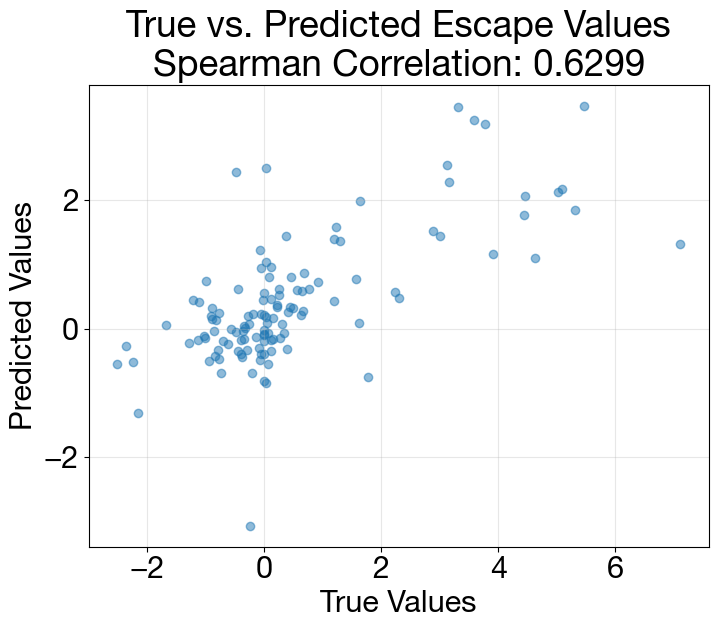

In [219]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Compute Spearman correlation
correlation, p_value = stats.spearmanr(y_val_original, y_pred_original)

# Print the correlation
print(f"Spearman Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4e}")

plt.figure(figsize=(8, 6))
plt.scatter(y_val_original, y_pred_original, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"True vs. Predicted Escape Values\nSpearman Correlation: {correlation:.4f}")
plt.grid(alpha=0.3)
plt.savefig("true_vs_predicted.png", dpi=1200, bbox_inches="tight")
plt.show()


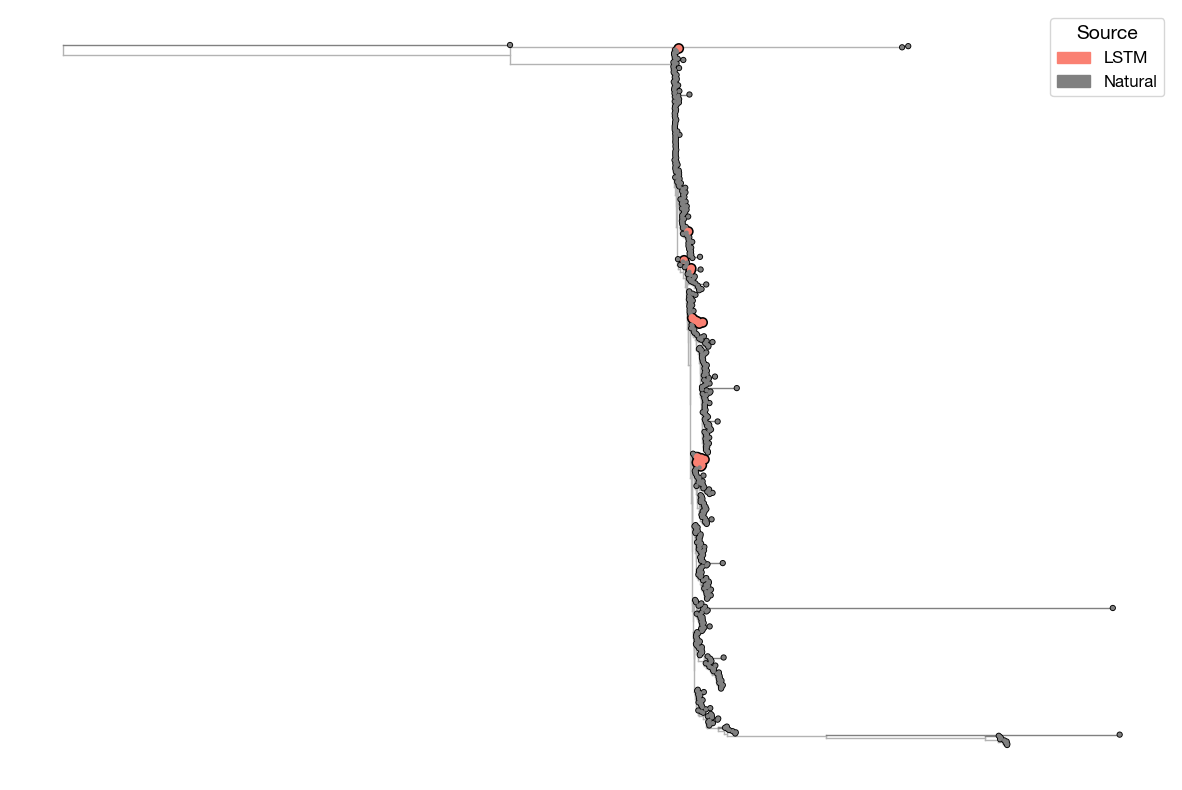

In [201]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Plot phylogenetic tree
import baltic as bt

treefile = 'Data/LSTM_Fullseqs.nwk'

tree = bt.loadNewick(treefile, absoluteTime=False, sortBranches=True)

for k in tree.Objects:
    if k.is_leaf():
        k.traits['Source'] = "LSTM" if "LSTM" in k.name else "Natural"

# Color and size functions
c_func = lambda x: 'salmon' if x.traits['Source'] == "LSTM" else 'gray'
s_func = lambda x: 30 if x.traits['Source'] == "LSTM" else 10

fig, ax = plt.subplots(figsize=(15, 10))

# Plot tree
tree.plotTree(ax, x_attr=lambda k: k.x, colour=c_func, width=1)
tree.plotPoints(ax, x_attr=lambda k: k.x, colour=c_func, size=s_func, zorder=1000)

# Remove spines and ticks
[ax.spines[loc].set_visible(False) for loc in ax.spines]
ax.tick_params(axis='x', size=0, labelsize=20)
ax.tick_params(axis='y', size=0, labelsize=0)
ax.set_yticks([]) 
ax.set_yticklabels([])
ax.set_xticks([]) 
ax.set_xticklabels([])

# Create a custom legend
legend_elements = [
    mpatches.Patch(color='salmon', label='LSTM'),
    mpatches.Patch(color='gray', label='Natural')
]
ax.legend(handles=legend_elements, title="Source", loc='upper right', fontsize=12, title_fontsize=14)


plt.savefig("phylogenetic_tree.png", dpi=1200, bbox_inches="tight")
plt.show()

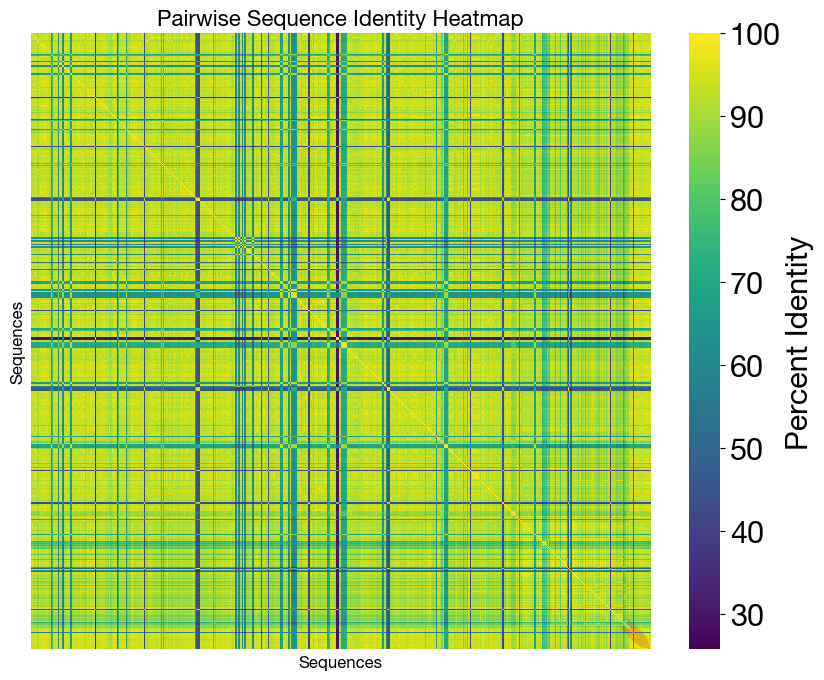

In [206]:
from Bio import AlignIO
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the alignment file
alignment_file = "Data/H5_clusters_rnn.aligned.fasta"  # Replace with your alignment file
alignment = AlignIO.read(alignment_file, "fasta")


# Get the number of sequences
num_seqs = len(alignment)

# Initialize pairwise identity matrix
identity_matrix = np.zeros((num_seqs, num_seqs))

# Function to calculate percent identity
def percent_identity(seq1, seq2):
    matches = sum(res1 == res2 for res1, res2 in zip(seq1, seq2))
    return (matches / len(seq1)) * 100

# Compute pairwise percent identity
for i in range(num_seqs):
    for j in range(num_seqs):
        identity_matrix[i, j] = percent_identity(alignment[i].seq, alignment[j].seq)

# Identify rows/columns with LSTM sequences
lstm_indices = [i for i, seq in enumerate(alignment) if "LSTM" in seq.id]


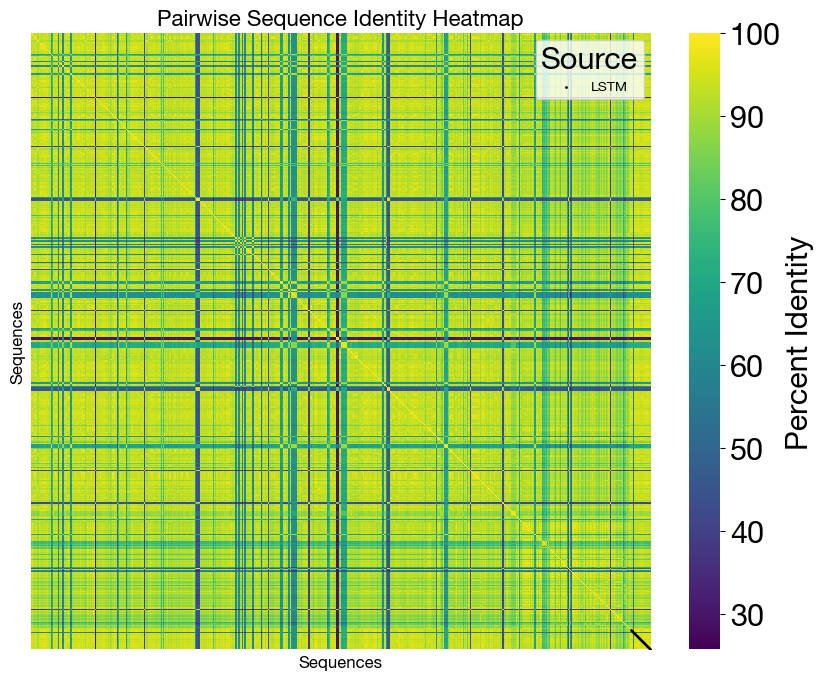

Mean pairwise similarity of LSTM sequences: 92.32%
Min pairwise similarity of LSTM sequences: 58.21%
Max pairwise similarity of LSTM sequences: 98.48%


In [221]:
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(identity_matrix, annot=False, cmap="viridis", xticklabels=False, yticklabels=False, cbar_kws={"label": "Percent Identity"})
plt.title("Pairwise Sequence Identity Heatmap", fontsize=16)
plt.xlabel("Sequences", fontsize=12)
plt.ylabel("Sequences", fontsize=12)

# Add colored squares or dots for LSTM sequences
for idx in lstm_indices:
    plt.scatter(idx + 0.5, idx + 0.5, color="black", s=1, label="LSTM" if idx == lstm_indices[0] else "")  # Add legend only once

# Add a custom legend
plt.legend(loc="upper right", title="Source", frameon=True, fontsize=10)

plt.savefig("pairwise_identity_heatmap.png", dpi=1200, bbox_inches="tight")
plt.show()

#Get mean similarity of LSTM sequences 
lstm_similarity = identity_matrix[lstm_indices][:, lstm_indices]
mean_similarity = np.mean(lstm_similarity[np.triu_indices(lstm_similarity.shape[0], k=1)])
print(f"Mean pairwise similarity of LSTM sequences: {mean_similarity:.2f}%")
#get min similarity
min_similarity = np.min(lstm_similarity[np.triu_indices(lstm_similarity.shape[0], k=1)])
print(f"Min pairwise similarity of LSTM sequences: {min_similarity:.2f}%")
#get max similarity
max_similarity = np.max(lstm_similarity[np.triu_indices(lstm_similarity.shape[0], k=1)])
print(f"Max pairwise similarity of LSTM sequences: {max_similarity:.2f}%")
